In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4,5"

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512 
tau_sim = 0.6     
DTS = 8     

# Glasma
su_group = 'su3'
Qs = 2.0     
ns = 50      
factor = 0.8        
uv = 10.0 

# Wong
quark = 'charm'    
mass = 1.275   
tau_form = 1/(2*mass)*hbarc    

# tau_sim += tau_form

initialization = 'pT'         
ntp = 10**5 

nevents = 2

representation = 'quantum fundamental'     
# representation = 'test'     
# representation = 'fundamental' 
# representation = 'adjoint' 
boundary = 'periodic'  
form_time = 'm'

# pTs = [0, 0.5, 1, 5]
# binning = 'pT2'
binning = 'pT'
npTbins = 21 
pTmax = 10
if binning=='pT':
    pTbins = np.linspace(0, pTmax, npTbins)
elif binning=='pT2':
    pTbins = np.linspace(0, pTmax**2, npTbins)
deltapTbin = pTbins[1] - pTbins[0]

In [2]:
# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,   
    'TFORM': tau_form,
    'TSIM': tau_sim,
    'QS': Qs,            
    'NEVENTS': nevents,
    'NTP': ntp,   
    'PTS': pTbins,
    'NPTBINS': npTbins,
    'PTMAX': pTmax,
    'REPR': representation,
    'SUGROUP': su_group,
    'FORMTIME': form_time,
    'BINNING': binning,
    }

In [3]:
# rest of parameters  
g2mu = p["QS"] / factor     
g = np.pi * np.sqrt(1 / np.log(p["QS"] / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g2mu     

tau_form = 1/(2*p["MASS"])*hbarc
tau_sim += tau_form

if representation == 'quantum fundamental':
    repr_name = 'qfund'
elif representation == 'fundamental':
    repr_name = 'fund'
elif representation == 'adjoint':
    repr_name = 'adj'
elif representation == 'test':
    repr_name = 'test'

# Results folder
folder = 'test_binning_RAA_' + p["QUARK"] + '_fonll_Qs_' + str(p["QS"]) + '_' + repr_name + '_' + p["SUGROUP"] + '_formt_' + p["FORMTIME"]

# filename = 'all_pTs_' + binning + '_bins.pickle'

In [4]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = p["SUGROUP"]

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
wong.WONG_TO_HOST = True
from curraun.wong import init_pos, init_charge, init_mom_toy
from curraun.particles_correlators import TransMom

Using CUDA
Using SU(3)
Using double precision
Using double precision


In [5]:
import pickle
from tqdm import tqdm

current_path = os.getcwd() 
results_folder = 'results'
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)
results_path = current_path + '/' + results_folder + '/'

In [6]:
def simulate(p, ev, pTbin, deltapTbin): 
    # Derived parameters
    a = L/N
    E0 = N/L * hbarc
    DT = 1.0 / DTS

    if p["FORMTIME"]=='m':
        tau_form = 1/(2*p["MASS"])*hbarc
    elif p["FORMTIME"]=='mT':
        # transverse mass
        mT = np.sqrt(p["MASS"]**2+pT**2)   
        # formation time given by inverse of transverse mass
        tau_form = 1/(2*mT)*hbarc

    p["TFORM"] = tau_form

    tau_sim = p["TSIM"] + tau_form 

    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

   
    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = p["MASS"] / E0 * np.ones(ntp)

    # pT bins
    binning=p["BINNING"]
    pTbinlow, pTbinhigh = pTbin, pTbin+deltapTbin
    uniform_pTbins = np.sort(np.random.uniform(pTbinlow, pTbinhigh, ntp))
    if binning=='pT':
        initial_pTbins = uniform_pTbins
    elif binning=='pT2':
        initial_pTbins = np.sqrt(uniform_pTbins)

    for i in range(ntp):
        # x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(representation)
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', initial_pTbins[i] / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0
    
    wong_solver.initialize(x0s, p0s, q0s, masses)

    final_pTbins = np.zeros((maxt-formt, ntp))
    compute_pT = TransMom(wong_solver, ntp)

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                compute_pT.compute()
                pTs = compute_pT.pT.copy() * E0
                if binning=='pT':
                    final_pTbins[t-formt] = pTs
                elif binning=='pT2':
                    final_pTbins[t-formt] = pTs ** 2

                # wong_solver.compute_mom_broad()
                
                wong_solver.evolve()

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    # output[str(pT)]['pTs_event_'+ str(ev+1)] = pTs
    # output[str(pT)]['initial_pTs_event_'+ str(ev+1)] = initial_pTs

    tau = np.linspace(0, tau_sim-tau_form, maxt-formt)
    # output['tau'] = tau

    return tau, final_pTbins, uniform_pTbins

In [7]:
print(p['QUARK'].capitalize() + " quark")
os.chdir(results_path)

# output = {}
# output['parameters'] = p.copy()
# output['pTs'] = p['PTS']
# output['nevents'] = p["NEVENTS"]

wong_folder = folder
if not os.path.isdir(wong_folder):
    os.makedirs(wong_folder)
wong_path = results_path + '/' + wong_folder + '/'
os.chdir(wong_path)

for ipT, pT in enumerate(p['PTS']):
    print("pT = " + str(pT) + " GeV")

    # output[str(pT)] = {}
    for iev, ev in enumerate(range(0, p["NEVENTS"])):
        # print("event " + str(iev+1))
        tau, final_pTs, initial_pTs = simulate(p, ev, pT, deltapTbin)

        filename_pT_ev = binning + '_bin_' + str(ipT+1) + '_ev_' + str(iev+1)
        np.savez_compressed(filename_pT_ev, pTs=final_pTs, initial_pTs=initial_pTs)

p["TAU"] = tau

with open('parameters_'+ binning +'_binning.pickle', 'wb') as handle:
    pickle.dump(p, handle)

Charm quark
pT = 0.0 GeV


Event 2: 100%|██████████| 277/277 [01:21<00:00,  3.40it/s]


pT = 0.5 GeV


Event 2: 100%|██████████| 277/277 [01:19<00:00,  3.49it/s]


pT = 1.0 GeV


Event 2: 100%|██████████| 277/277 [01:31<00:00,  3.03it/s]


pT = 1.5 GeV


Event 2: 100%|██████████| 277/277 [01:22<00:00,  3.35it/s]


pT = 2.0 GeV


Event 2: 100%|██████████| 277/277 [01:37<00:00,  2.84it/s]


pT = 2.5 GeV


Event 2: 100%|██████████| 277/277 [01:26<00:00,  3.20it/s]


pT = 3.0 GeV


Event 2: 100%|██████████| 277/277 [01:31<00:00,  3.03it/s]


pT = 3.5 GeV


Event 2: 100%|██████████| 277/277 [01:34<00:00,  2.92it/s]


pT = 4.0 GeV


Event 2: 100%|██████████| 277/277 [01:45<00:00,  2.64it/s]


pT = 4.5 GeV


Event 2: 100%|██████████| 277/277 [01:35<00:00,  2.90it/s]


pT = 5.0 GeV


Event 2: 100%|██████████| 277/277 [01:40<00:00,  2.76it/s]


pT = 5.5 GeV


Event 2: 100%|██████████| 277/277 [01:42<00:00,  2.71it/s]


pT = 6.0 GeV


Event 2: 100%|██████████| 277/277 [01:36<00:00,  2.86it/s]


pT = 6.5 GeV


Event 2: 100%|██████████| 277/277 [01:16<00:00,  3.63it/s]


pT = 7.0 GeV


Event 2: 100%|██████████| 277/277 [01:18<00:00,  3.51it/s]


pT = 7.5 GeV


Event 2: 100%|██████████| 277/277 [01:16<00:00,  3.64it/s]


pT = 8.0 GeV


Event 2: 100%|██████████| 277/277 [01:16<00:00,  3.64it/s]


pT = 8.5 GeV


Event 2: 100%|██████████| 277/277 [01:25<00:00,  3.25it/s]


pT = 9.0 GeV


Event 2: 100%|██████████| 277/277 [01:14<00:00,  3.72it/s]


pT = 9.5 GeV


Event 2: 100%|██████████| 277/277 [01:15<00:00,  3.67it/s]


pT = 10.0 GeV


Event 2: 100%|██████████| 277/277 [01:22<00:00,  3.34it/s]


---
#### Simple script to extract $R_{AA}$.

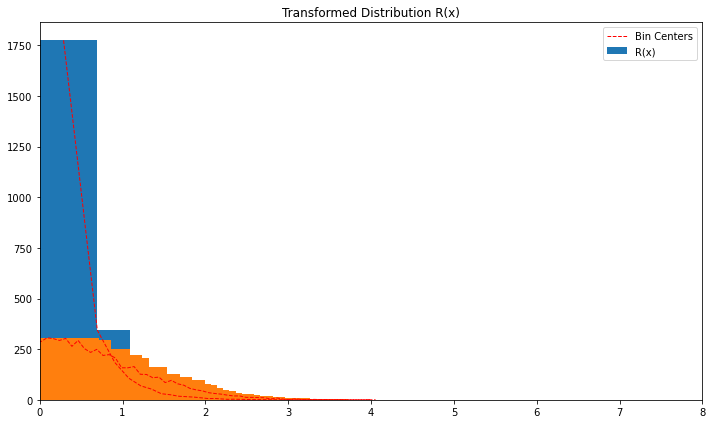

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have histograms for R(x^2)
# Replace the following lines with your actual data
x2_values, x2_edges = np.histogram(np.random.normal(0, 1, 10000)**2, bins=50, density=False)
x2_midpoints = 0.5 * (x2_edges[1:] + x2_edges[:-1])

# Transformation factor
transformation_factor = 1 / (2 * np.sqrt(x2_midpoints))

# Transform x^2 histogram to x histogram
R_x_values = x2_values * transformation_factor * np.diff(x2_edges)

# Obtain x values from x^2 midpoints
x_midpoints = 0.5 * (np.sqrt(x2_edges[1:]) + np.sqrt(x2_edges[:-1]))
# x_values = np.sqrt(x2_midpoints)
x_values = x_midpoints

x_true_values, x_true_edges = np.histogram(np.random.normal(0, 1, 10000), bins=100, density=False)
x_true_midpoints = 0.5 * (x_true_edges[1:] + x_true_edges[:-1])

# Plotting histograms for R(x^2) and R(x)
plt.figure(figsize=(10, 6))

# plt.subplot(2, 1, 1)
# plt.bar(x2_midpoints, x2_values, width=np.diff(x2_edges), label='R(x^2)')
# plt.plot(x2_midpoints, x2_values, color='red', linestyle='dashed', linewidth=1, label='Bin Centers')
# plt.title('Original Distribution R(x^2)')
# plt.legend()
# plt.xlim(0,16)

# Corrected: Plot R(x) as a function of x
# plt.subplot(2, 1, 2)
plt.bar(x_values, R_x_values, label='R(x)')
plt.plot(x_values, R_x_values, color='red', linestyle='dashed', linewidth=1, label='Bin Centers')
# plt.bar(x2_midpoints, R_x_values, label='R(x)')
# plt.plot(x2_midpoints, R_x_values, color='red', linestyle='dashed', linewidth=1, label='Bin Centers')
plt.title('Transformed Distribution R(x)')
plt.legend()
plt.xlim(0,8)

plt.bar(x_true_midpoints, x_true_values, label='R(x)')
plt.plot(x_true_midpoints, x_true_values, color='red', linestyle='dashed', linewidth=1, label='Bin Centers')

plt.tight_layout()
plt.show()


In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate R(x) data
def generate_Rx_data(x_values):
    return np.exp(-x_values / 2) / np.sqrt(2 * np.pi)

# Function to transform R(x) to R(x^2)
def transform_Rx_to_Rx2(x_values, Rx_values):
    x2_values = x_values**2
    bin_midpoints_x = (x_values[:-1] + x_values[1:]) / 2  # Calculate bin midpoints for x
    transformation_factor = 1 / (2 * np.sqrt(bin_midpoints_x))
    Rx2_values = Rx_values * transformation_factor * np.diff(x_values)
    # return x2_values, Rx2_values
    return bin_midpoints_x, Rx2_values

# Function to transform R(x^2) back to R(x)
def transform_Rx2_to_Rx(x2_values, Rx2_values):
    x_values = np.sqrt(x2_values)
    bin_midpoints_x2 = (x2_values[:-1] + x2_values[1:]) / 2  # Calculate bin midpoints for x^2
    transformation_factor = 1 / (2 * bin_midpoints_x2)
    Rx_values = Rx2_values / (transformation_factor * np.diff(x2_values))
    # return x_values, Rx_values
    return bin_midpoints_x2, Rx_values

# Generate data for R(x)
x_values = np.linspace(0.01, 5, 100)
Rx_values = generate_Rx_data(x_values)

# Transform R(x) to R(x^2)
x2_values, Rx2_values = transform_Rx_to_Rx2(x_values, Rx_values)

# Transform R(x^2) back to R(x)
x_transformed, Rx_transformed = transform_Rx2_to_Rx(x2_values, Rx2_values)

# Plotting histograms for R(x) and R(x) transformed
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.bar(x_values, Rx_values, width=np.diff(x_values), label='R(x)')
plt.title('Original Distribution R(x)')
plt.legend()

plt.subplot(2, 1, 2)
# plt.bar(x_transformed, Rx_transformed, width=np.diff(x_values), label='Transformed R(x)')
plt.title('Transformed Distribution R(x)')
plt.legend()

plt.tight_layout()
plt.show()


TypeError: 'NoneType' object is not iterable

In [1]:
import numpy as np
import os
import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

import seaborn as sns
from scipy import interpolate
import scipy.integrate as integrate
import matplotlib.pyplot as plt

Read data from file. The results are stored in `folder`. 

In [2]:
current_path = os.getcwd() 
results_folder = 'results'
results_path = current_path + '/' + results_folder + '/'
folder= "test_RAA_charm_fonll_Qs_2.0_fund_su2_formt_m"

Choose the proper time slice $\tau_\mathrm{stop}$ at which the Glasma $p_T$ values are extracted.

In [3]:
tau_stop = 0.4

Read the Glasma parameters from a `pickle` dictionary. Here the proper time $\Delta\tau=tau-tau_\mathrm{form}$ is also stored.

In [4]:
with open(results_path+folder+'/parameters.pickle', 'rb') as f:
    parameters = pickle.load(f)
tau_sim = parameters['TAU']

Find the index of $\tau_\mathrm{stop}$ in $\Delta\tau$.

In [5]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

Read all the results files from `folder`. They are stored in `*.npz` files, per $p_T$ bin and event number. Each $p_T$ bin contains $p_T$ values uniformly distributed within that bin and $N_\mathrm{tp}$ test particles. All initial $p_T(\tau_\mathrm{form})$ and $p_T(\tau_\mathrm{stop})$ are stored in lists.

In [6]:
pTs_tauform, pTs_taustop = [], []
sqpTs_tauform, sqpTs_taustop = [], []
id = []

counter = 1
for ifile, file in enumerate(os.listdir(results_path+folder)):
    if file.endswith('.npz'):
        result = np.load(results_path+folder+'/'+file)
        initial_pTs, pTs = result['initial_pTs'], result['pTs']
        for itp in range(parameters['NTP']):
            pTs_tauform.append(initial_pTs[itp])
            sqpTs_tauform.append(initial_pTs[itp]**2)
            tau_index = find_nearest(tau_sim, tau_stop)
            pTs_taustop.append(pTs[tau_index, itp])
            sqpTs_taustop.append(pTs[tau_index, itp]**2)
            # id.append(str((itp+1)*(ifile+1)))
            id.append(str(counter))
            counter += 1

Construct a data frame from the collected $p_T$ values. Each line is unique to each test particle and contains the initial $p_T(\tau_\mathrm{form})$ and $p_T(\tau_\mathrm{stop})$.

In [7]:
collect_df = np.column_stack((pTs_tauform, pTs_taustop, sqpTs_tauform, sqpTs_taustop))
df = pd.DataFrame(collect_df, columns = ['Initial pT','Final pT', 'Initial pT^2','Final pT^2'], index=id)

Sort the data frames by the value of the initial $p_T(\tau_\mathrm{form})$. This will be useful for the next step (the FONLL interpolation map will be applied on the initial $p_T(\tau_\mathrm{form})$ values).

In [8]:
df = df.sort_values(by=['Initial pT'])

In [9]:
df

,Initial pT,Final pT,Initial pT^2,Final pT^2
10001,0.000017,0.904478,3.057815e-10,0.818080
1,0.000026,1.021121,6.914065e-10,1.042688
2,0.000069,0.635074,4.802136e-09,0.403319
3,0.000122,0.969777,1.493208e-08,0.940468
4,0.000167,0.346532,2.799449e-08,0.120084
...,...,...,...,...
219996,10.999894,10.276287,1.209977e+02,105.602066
219997,10.999937,11.273129,1.209986e+02,127.083439
219998,10.999941,9.917108,1.209987e+02,98.349040
219999,10.999951,11.561095,1.209989e+02,133.658925


---
Read the initial FONLL spectra from file.

In [10]:
energy = 5500
pdf = "cteq"
quark = "charm"
version = "dsdpt"
# version = "d2sdpt2"
# filename_fonll = "/fonll_" + version +"_" + quark + "_" + str(energy) + "_" + pdf + ".txt"
filename_fonll = "/fonll_dsdpt_" + quark + "_" + str(energy) + "_" + pdf + "_more_points.txt"
fonll = np.loadtxt(current_path + filename_fonll, comments='#')

Interpolate the data and store the corresponding FONLL weights as a column in the dataframe `df`. This column will give the weights in the histogram and is obtained by applying the FONLL interpolation map to the vector of initial $p_T(\tau_\mathrm{form})$.

In [11]:
pt_fonll, dsdpt_fonll = fonll[:, 0], fonll[:, 1]
if version=="dsdpt":
    fonll_interp_map = interpolate.interp1d(pt_fonll, dsdpt_fonll)
    fonll_tauform = fonll_interp_map(df['Initial pT'])
    df['FONLL pT weight'] = fonll_tauform
elif version=="d2sdpt2":
    pt2_fonll, d2sdpt2_fonll = pt_fonll**2, dsdpt_fonll/pt_fonll
    # The first point is (0, inf)
    pt2_fonll, d2sdpt2_fonll = pt2_fonll[1:len(pt2_fonll)], d2sdpt2_fonll[1:len(d2sdpt2_fonll)]
    fonll_interp_map = interpolate.interp1d(pt2_fonll, d2sdpt2_fonll, fill_value="extrapolate")
    fonll_tauform = fonll_interp_map(df['Initial pT^2'])
    df['FONLL pT^2 weight'] = fonll_tauform

In [12]:
df

,Initial pT,Final pT,Initial pT^2,Final pT^2,FONLL pT weight
10001,0.000017,0.904478,3.057815e-10,0.818080,3.861015e+03
1,0.000026,1.021121,6.914065e-10,1.042688,5.805808e+03
2,0.000069,0.635074,4.802136e-09,0.403319,1.530077e+04
3,0.000122,0.969777,1.493208e-08,0.940468,2.698088e+04
4,0.000167,0.346532,2.799449e-08,0.120084,3.694300e+04
...,...,...,...,...,...
219996,10.999894,10.276287,1.209977e+02,105.602066,2.894728e+06
219997,10.999937,11.273129,1.209986e+02,127.083439,2.894680e+06
219998,10.999941,9.917108,1.209987e+02,98.349040,2.894675e+06
219999,10.999951,11.561095,1.209989e+02,133.658925,2.894663e+06


Plot the FONLL distribution read from the files and the interpolated one.

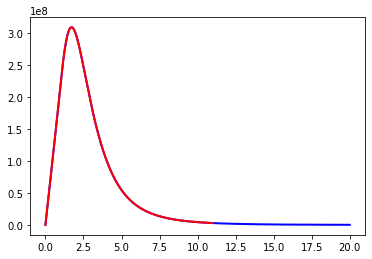

In [13]:
fig, ax = plt.subplots(1, 1)

if version=="dsdpt":
    ax.plot(pt_fonll, dsdpt_fonll, linewidth=2, color='blue')
    ax.plot(df['Initial pT'], fonll_tauform, linewidth=2, color='red')
elif version=="d2sdpt2":
    ax.plot(pt_fonll[1:len(pt_fonll)], d2sdpt2_fonll, linewidth=2, color='blue')
    ax.plot(df['Initial pT'], fonll_tauform, linewidth=2, color='red')
    plt.yscale("log")

# fig.patch.set_facecolor('white')

In [15]:
# pTs_col = np.concatenate((df['Initial pT'].to_numpy(), df['Final pT'].to_numpy()))
# types_col = np.concatenate((['Initial'] * len(df['Initial pT']),['Final'] * len(df['Final pT'])))

# collect_df_pTs = np.column_stack((pTs_col, types_col))
# df_pTs = pd.DataFrame(collect_df_pTs, columns = ['pT','Type'])

Plot the initial flat $p_T(\tau_\mathrm{form})$ (gray) distribution and the distribution of $p_T(\tau_\mathrm{stop})$ (blue) after evolving in the Glasma.

In [14]:
pt_bins = np.arange(0, 16, 0.4)
if version=="d2sdpt2":
    pt2_bins = [pt**2 for pt in pt_bins]
norm = 'density'
# norm = 'count'

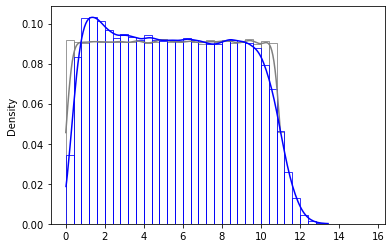

In [15]:
if version=="dsdpt":
    sns.histplot(np.array(df['Initial pT']), color='gray', bins=pt_bins, kde=True, fill=False, stat=norm)
    sns.histplot(np.array(df['Final pT']), color='blue', bins=pt_bins, kde=True, fill=False, stat=norm)
elif version=="d2sdpt2":
    sns.histplot(np.array(df['Initial pT^2']), color='gray', bins=pt2_bins, kde=True, fill=False, stat=norm)
    sns.histplot(np.array(df['Final pT^2']), color='blue', bins=pt2_bins, kde=True, fill=False, stat=norm)
    plt.yscale("log")

plt.show()

<AxesSubplot:xlabel='Initial pT', ylabel='Final pT'>

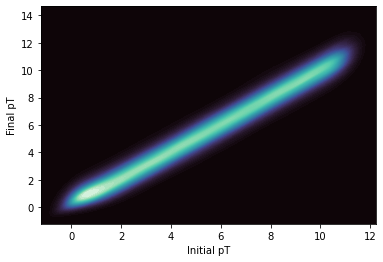

In [64]:
sns.kdeplot(data=df, x="Initial pT", y="Final pT",fill=True, thresh=0, levels=100, cmap="mako")

In [26]:
# if type=='kde':
#     sns.kdeplot(np.array(df['Initial pT']), color='gray')
#     sns.kdeplot(np.array(df['Final pT']), color='blue')
# elif type=='hist':
#     sns.histplot(np.array(df['Initial pT']), color='gray', bins=50)
#     sns.histplot(np.array(df['Final pT']), color='blue', bins=50)

Remove duplicates (for the same initial $p_T(\tau_\mathrm{form})$ there are multiple entries in `df` but `kde` or `hist` cannot be constructed when there are duplicate entries.

In [41]:
#TODO Remove this, it's unnecesary. There was a problem with indexing, now it is fixed
# Remove duplicates in df
# df_unique = df[~df.index.duplicated()]

Construct the histrogram of $p_T(\tau_\mathrm{stop})$ with weights given by the corresponding $\mathrm{FONLL}(p_T(\tau_\mathrm{form}))$ for that specific test particle. 

In [16]:
dens = {}

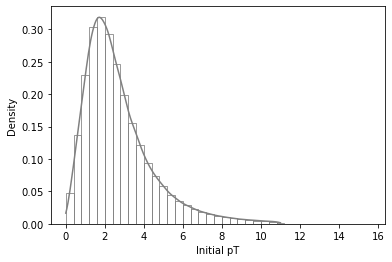

In [17]:
# dens["tau_form"] = sns.histplot(data=df, x="Initial pT", weights="FONLL weight", color='gray', bins=40, kde=True, stat=norm)
if version=="dsdpt":
    dens["tau_form"] = sns.histplot(data=df, x="Initial pT", weights="FONLL pT weight", color='gray', bins=pt_bins, kde=True, stat=norm, fill=False)
elif version=="d2sdpt2":
    dens["tau_form"] = sns.histplot(data=df, x="Initial pT^2", weights="FONLL pT^2 weight", color='gray', bins=pt2_bins, kde=True, stat=norm, fill=False)
    plt.yscale("log")

Extract the values from the density plot, in order to compute $R_{AA}$.

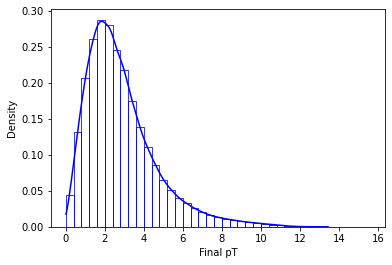

In [18]:
# dens["tau_stop"] = sns.histplot(data=df, x="Final pT", weights="FONLL weight", color='blue', bins=40, kde=True, stat=norm)
if version=="dsdpt":
    dens["tau_stop"] = sns.histplot(data=df, x="Final pT", weights="FONLL pT weight", color='blue', bins=pt_bins, kde=True, stat=norm, fill=False)
elif version=="d2sdpt2":
    dens["tau_stop"] = sns.histplot(data=df, x="Final pT^2", weights="FONLL pT^2 weight", color='blue', bins=pt2_bins, kde=True, stat=norm, fill=False)
    plt.yscale("log")

Extract `kde` and `hist` values from the axes.

In [19]:
dens_x, dens_y = {}, {}
for it, tau_i in enumerate(["tau_form", "tau_stop"]):
    dens_x[tau_i], dens_y[tau_i] = {}, {}
    dens_x[tau_i]["kde"], dens_y[tau_i]["kde"] = dens[tau_i].get_lines()[0].get_data()[0], dens[tau_i].get_lines()[0].get_data()[1]
    dens_x[tau_i]["hist"], dens_y[tau_i]["hist"] = np.array([h.xy[0] for h in dens[tau_i].patches]), np.array([h.get_height() for h in dens[tau_i].patches])

Check normalization of spectra.

In [20]:
if version=="dsdpt":
    for tau_i in ["tau_form", "tau_stop"]:
        print(tau_i)
        for type in ["kde", "hist"]:
            print(type)
            print(integrate.simps(dens_y[tau_i][type], dens_x[tau_i][type]))

tau_form
kde
0.99795226117563
hist
0.9940320138357314
tau_stop
kde
0.9979887562646427
hist
0.995152614373054


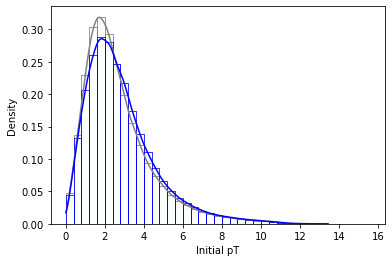

In [21]:
if version=="dsdpt":
    sns.histplot(data=df, x="Initial pT", weights="FONLL pT weight", color='gray', bins=pt_bins, kde=True, stat=norm, fill=False)
    sns.histplot(data=df, x="Final pT", weights="FONLL pT weight", color='blue', bins=pt_bins, kde=True, stat=norm, fill=False)
elif version=="d2sdpt2":
    sns.histplot(data=df, x="Initial pT^2", weights="FONLL pT^2 weight", color='gray', bins=pt2_bins, kde=True, stat=norm, fill=False)
    sns.histplot(data=df, x="Final pT^2", weights="FONLL pT^2 weight", color='blue', bins=pt2_bins, kde=True, stat=norm, fill=False)
    plt.yscale("log")

/n/work00/davrames/condacurraun/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/n/work00/davrames/condacurraun/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


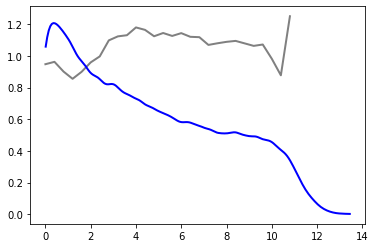

In [22]:
fig_ratio, ax_ratio = plt.subplots(1, 1)

colors = ['gray', 'blue']
for it, type in enumerate(["hist", "kde"]):
    ratio = np.array(dens_y["tau_stop"][type])/np.array(dens_y["tau_form"][type])
    ax_ratio.plot(dens_x["tau_stop"][type], ratio, linewidth=2, color=colors[it])

# type_plot = "kde"
# for it, tau in enumerate(["tau_form", "tau_stop"]):
#     ax_ratio.plot(dens_x[tau][type_plot], dens_y[tau][type_plot], linewidth=1.5, color=colors[it])
# ax_ratio.plot(dens_x["tau_stop"][type_plot], dens_y["tau_stop"][type_plot]/dens_y["tau_form"][type_plot], linewidth=2, color=colors[it])

# dens_x_pos = dens_x["tau_form"][dens_x["tau_form"]>=0]
# dens_y_fonll = fonll_interp_map(dens_x_pos)/integrate.simps(dens_x_pos, fonll_interp_map(dens_x_pos))*(-1)
# ax_ratio.plot(dens_x_pos, dens_y_fonll, linewidth=2, color='purple')

# ax2.plot(dens_x["tau_form"], np.ones(len(dens_x["tau_form"])), linewidth=2, color='gray')
# ax2.plot(dens_x["tau_form"], dens_y["tau_stop"]/dens_y["tau_form"], linewidth=2, color='red')
# ax2.set_xlim(0, 2)